# 0. Setup

In [48]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize

from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')



In [49]:
### Helper functions

def covariance_calc(H, k):
    #Calculation derived in dissertation.
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality. Numbers calculated by hand
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)

    #Calculate one column, then use this to populate rest of lower triangle of matrix
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right. Numbers calculated by hand. 
assert_almost_equal(get_covariance_matrix(3, 0.25), np.array([[1, -0.2928932, -0.0481881], [-0.2928932, 1, -0.2928932], [-0.0481881, -0.2928932, 1]]))

#This function needed because not all Brownian motion files start with 0, and they should for consistency
def add_zero(path):
    if path[0,] != 0:
        path = np.insert(path, 0, 0)
    return path
    
test1 = np.array([1, 2, 3])
test2 = np.array([0, -1, -2, -3])
assert_almost_equal(np.array([0, 1, 2, 3]), add_zero(test1))
assert_almost_equal(test2, add_zero(test2))

def get_diffs(path):
    # Get the differences of a path i.e. the individual increments
    return path[1:] - path[:-1]

assert_almost_equal(get_diffs(np.array([1, 1, 1, 1, 1])), np.array([0, 0, 0, 0]))
assert_almost_equal(get_diffs(np.array([1, 2, 3, 4, 5])), np.array([1, 1, 1, 1]))

#Get spot variances in spanned sets of a path
def estimate_spot_variance(S_path, span):
    #Check can divide range into equal sub-sections
    assert_almost_equal((S_path.shape[0] - 1) % span, 0)
    n_windows = (S_path.shape[0] - 1) / span

    log_returns = np.log(S_path[1:]/S_path[:-1])
    spanned_returns = np.split(log_returns, n_windows)

    spot_variances = np.zeros(int(n_windows))

    for i, v in enumerate(spanned_returns):
        spot_variances[i] = np.var(v)

    return spot_variances

test_path = np.arange(1, 22)
assert_almost_equal(estimate_spot_variance(test_path, 10), np.array([0.031131074, 0.000145955]))




In [50]:
def simulate_fbm(n_sims, n_steps, T, H):

    rng = np.random.default_rng(seed = 1729)

    cov_mat = get_covariance_matrix(n_steps, H)
    L = np.linalg.cholesky(cov_mat)
    
    variates = rng.normal(loc = 0, scale = 1, size = [n_sims, n_steps])
    corr_variates = (L @ variates.T).T

    B = np.zeros([n_sims, n_steps + 1])

    for i in range(0, n_steps):
        B[:, i + 1] = B[:, i] + corr_variates[:, i]

    return B * (T/n_steps) ** (H)


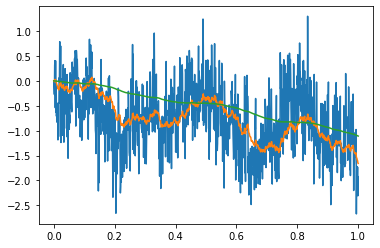

In [51]:
n_steps = 1024
T = 1

span = np.linspace(0, T, n_steps + 1)

out = simulate_fbm(1, n_steps, T, 0.05)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.5)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.95)
plt.plot(span, out.T)

In [52]:
def H_estimator(x, T):
    #return estimator of H from dissertation. Assume q = 2. 
    n_steps = x.shape[0]
    
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    diffs = diffs = x[1:] - x[:-1]

    return np.log(np.dot(diffs, diffs)) / np.log(T / n_steps)


# 1. MLE

In [53]:

def obj(H, x, T):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)
    scalar = (T / n_steps) ** (2 * H)

    determinant = np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar

    return np.log(determinant) + n_steps * np.log(scalar) + n_steps * np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) 
    

def max_MLE(x, T):

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]

    #initial_guess = H_estimator(x, T)
    initial_guess = 0.5

    #Convergence issues noticed around H = 0.95, setting a bound of 0.94
    #Set lower bound of floating epsilon to stop H hitting exactly 0, which will cause LLF errors
    H = minimize(obj, initial_guess, args = (diffs, T), bounds = [(np.finfo(float).eps, 0.94)], method = "Powell", tol = 1e-10)

    if H.success:
        H_hat = H.x[0]
        R = get_covariance_matrix(n_steps, H_hat)
        scalar = (T / n_steps) ** (2 * H_hat)
        R_inv = np.linalg.inv(R) / scalar
        sigma_hat = np.sqrt(1 / n_steps * np.dot(diffs.T, np.dot(R_inv, diffs)))
        return H_hat, sigma_hat

    return H.success

In [54]:
# Check this code works for a selection of cases

test_vals = np.arange(0.05, 0.9, 0.05)
test_scalars = np.arange(0.5, 2, 0.5)
val_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
scalar_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
for i, i_val in enumerate(test_vals):
    for j, j_val in enumerate(test_scalars):
        test_sim = simulate_fbm(1, 1024, 1, i_val)
        test_sim = test_sim[0, :].T * j_val
        test_H = max_MLE(test_sim, 1)
        val_errors[i, j] = test_H[0] - i_val
        scalar_errors[i, j] = test_H[1] - j_val
    

In [55]:
val_errors

array([[0.0028441 , 0.00284409, 0.00284408],
       [0.00267591, 0.00267592, 0.00267592],
       [0.00276498, 0.00276498, 0.00276499],
       [0.00301798, 0.00301794, 0.00301798],
       [0.00334684, 0.00334684, 0.00334687],
       [0.00369966, 0.00369965, 0.00369965],
       [0.00404885, 0.00404889, 0.00404887],
       [0.00438125, 0.00438125, 0.00438126],
       [0.00469182, 0.00469178, 0.00469176],
       [0.00497959, 0.00497965, 0.00497974],
       [0.00524652, 0.00524646, 0.00524632],
       [0.00549444, 0.00549435, 0.00549412],
       [0.00572622, 0.00572595, 0.00572553],
       [0.00594178, 0.00594178, 0.00594164],
       [0.00613998, 0.00613995, 0.00613908],
       [0.00630617, 0.00630617, 0.00630602],
       [0.08999999, 0.08999999, 0.08999999]])

In [56]:
scalar_errors

array([[-3.87268574e-03, -7.74539135e-03, -1.16181647e-02],
       [-3.81815954e-03, -7.63629382e-03, -1.14544426e-02],
       [-3.27262786e-03, -6.54529531e-03, -9.81783994e-03],
       [-2.28483702e-03, -4.56990859e-03, -6.85448986e-03],
       [-1.06128485e-03, -2.12258790e-03, -3.18364697e-03],
       [ 2.59206801e-04,  5.18360840e-04,  7.77463860e-04],
       [ 1.60062830e-03,  3.20149760e-03,  4.80207372e-03],
       [ 2.92907153e-03,  5.85814306e-03,  8.78722900e-03],
       [ 4.23728239e-03,  8.47425437e-03,  1.27111938e-02],
       [ 5.53437415e-03,  1.10691536e-02,  1.66047227e-02],
       [ 6.84511105e-03,  1.36897981e-02,  2.05331642e-02],
       [ 8.20336425e-03,  1.64060734e-02,  2.46066383e-02],
       [ 9.66354543e-03,  1.93250066e-02,  2.89827515e-02],
       [ 1.12992308e-02,  2.25984617e-02,  3.38960550e-02],
       [ 1.32397320e-02,  2.64791678e-02,  3.97079542e-02],
       [ 1.56896592e-02,  3.13793184e-02,  4.70669613e-02],
       [ 8.53391862e-01,  1.70678372e+00

In [57]:
sample_fbm = np.loadtxt('C:\\Users\\jamma\\Masters\\Dissertation\\fBMPath2.txt')
res = max_MLE(sample_fbm, 1)
res


(0.035675424351465715, 1.1596978410643553)

# 2. Simulation

In [58]:
B_path_loc = 'C:\\Users\\jamma\\Masters\\Dissertation\\Bpath.05.txt'
BH_path_loc = 'C:\\Users\\jamma\\Masters\\Dissertation\\BHpath.05.txt'
W_path_loc = 'C:\\Users\\jamma\\Masters\\Dissertation\\Wpath.05.txt'


def simulate_RFSV(B_path_loc, BH_path_loc, W_path_loc):
    B_path = add_zero(np.loadtxt(B_path_loc))
    BH_path = add_zero(np.loadtxt(BH_path_loc))
    W_path = add_zero(np.loadtxt(W_path_loc))

    B_diffs = get_diffs(B_path)
    W_diffs = get_diffs(W_path)

    n_steps = B_diffs.shape[0]

    S_path = np.zeros(n_steps + 1)
    V_path = np.zeros(n_steps + 1)

    V0 = 0.1
    S0 = 1
    v = 1
    rho = -0.65
    rho_bar = np.sqrt(1 - rho ** 2)

    V_path = V0 * np.exp(v * BH_path)

    # Assume some values for S0, V0
    S_path[0] = S0
    
    for i in range(n_steps):
        S_path[i + 1] = S_path[i] *\
              (1 + np.sqrt(V_path[i]) *\
              (rho * B_diffs[i] + rho_bar * W_diffs[i]))
        
    return V_path, S_path


V_path, S_path = simulate_RFSV(B_path_loc, BH_path_loc, W_path_loc)
estimate_spot_variance(V_path, 16)

array([0.65961145, 0.31548865, 0.52738173, ..., 0.36177651, 0.30971986,
       0.40212803])